In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
df = pd.read_csv("data/medical_insurance.csv", sep=",")
df = df.drop_duplicates()

In [3]:
le_smoker = LabelEncoder()
df["smoker"] = le_smoker.fit_transform(df["smoker"])

le_sex = LabelEncoder()
df["sex"] = le_sex.fit_transform(df["sex"])

oh_region = OneHotEncoder()
encoded_region = oh_region.fit_transform(df[["region"]])
encoded_region = pd.DataFrame(encoded_region.toarray(), columns=["northeast", "northwest", "southeast", "southwest"])
df.drop(columns=["region"], inplace=True)
df = pd.merge(df, encoded_region, left_index=True, right_index=True)

c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


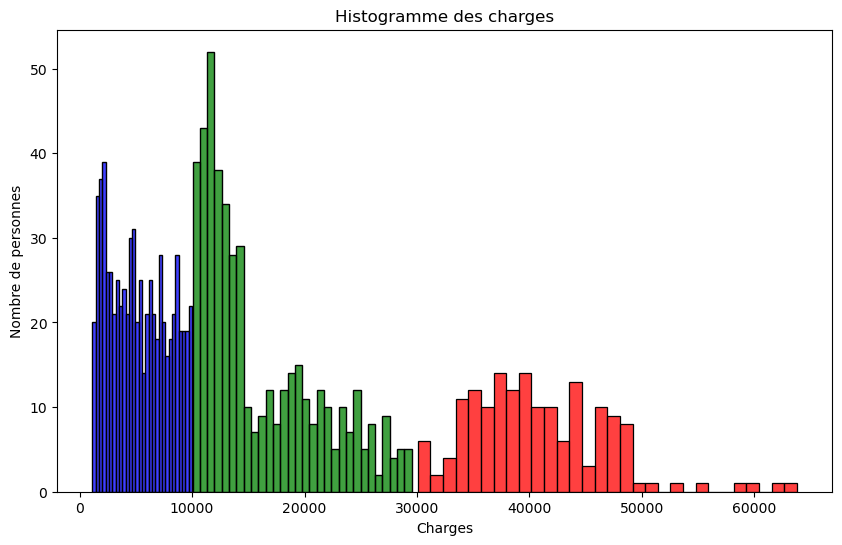

Nombre de personnes avec des charges < 10000 :  711
Nombre de personnes avec des charges entre 10000 et 30000 :  463
Nombre de personnes avec des charges > 30000 :  162


In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df["charges"] < 10000]["charges"], color="blue", bins=30)
sns.histplot(df[(df["charges"] >= 10000) & (df["charges"] <= 30000)]["charges"], color="green", bins=30)
sns.histplot(df[df["charges"] > 30000]["charges"], color="red", bins=30)
plt.xlabel("Charges")
plt.ylabel("Nombre de personnes")
plt.title("Histogramme des charges")
plt.show()
# On affiche le nombre de chaque groupe
print("Nombre de personnes avec des charges < 10000 : ", len(df[df["charges"] < 10000]))
print("Nombre de personnes avec des charges entre 10000 et 30000 : ", len(df[(df["charges"] >= 10000) & (df["charges"] <= 30000)]))
print("Nombre de personnes avec des charges > 30000 : ", len(df[df["charges"] > 30000]))

In [5]:
# On tente de prédire les coûts d'assurance en fonction des autres variables
# En trois groupes : 0-10000, 10000-30000, >30000
df['charges_group'] = pd.cut(df['charges'], bins=[0, 10000, 30000, np.inf], labels=[0, 1, 2])

# On enlève la variable charges
df = df.drop(columns=['charges'])

In [8]:
# Nearest kneighbors classifier
from sklearn.neighbors import KNeighborsClassifier

X = df.drop(columns=['charges_group'])
y = df['charges_group']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [9]:
# On prédit les valeurs
y_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.7723880597014925


In [10]:
# On regarde les valeurs prédites pour être sûr qu'il ne prédit pas toujours la même chose
np.unique(y_pred, return_counts=True)

(array([0, 1, 2], dtype=int64), array([183,  77,   8], dtype=int64))

100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


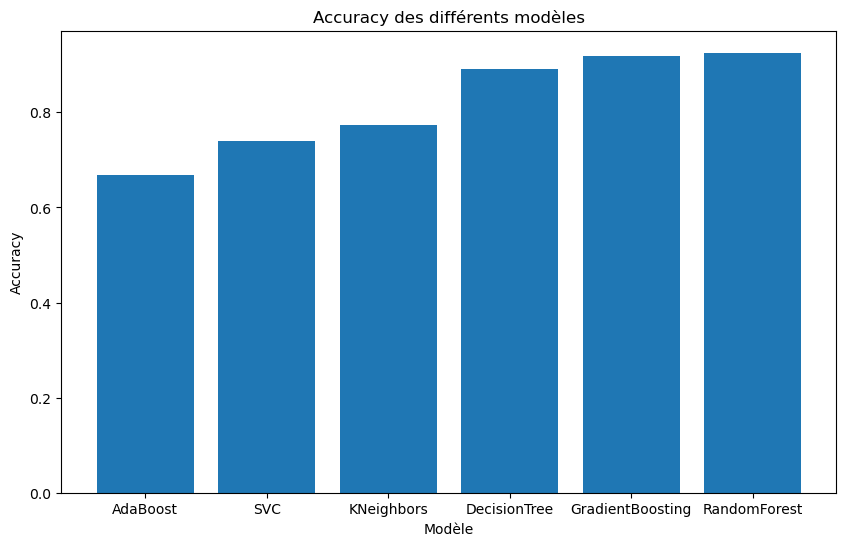

[['AdaBoost' '0.667910447761194']
 ['SVC' '0.7388059701492538']
 ['KNeighbors' '0.7723880597014925']
 ['DecisionTree' '0.8917910447761194']
 ['GradientBoosting' '0.917910447761194']
 ['RandomForest' '0.9253731343283582']]


In [20]:
# On compare différents algorithmes de classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = {
    "AdaBoost": AdaBoostClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "KNeighbors": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(),
    "SVC": SVC()
}   

from tqdm import tqdm

results = []
for model_name, model in tqdm(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((model_name, accuracy))
    
results = np.array(results)
results = results[np.argsort(results[:, 1])]
plt.figure(figsize=(10, 6))
plt.bar(results[:, 0], results[:, 1].astype(float))
plt.xlabel("Modèle")
plt.ylabel("Accuracy")
plt.title("Accuracy des différents modèles")
plt.show()

print(results)

In [21]:
# On regarque ce que réponds le RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
np.unique(y_pred, return_counts=True)

(array([0, 1, 2], dtype=int64), array([154,  90,  24], dtype=int64))

In [22]:
# On peut voir que le RandomForestClassifier est le meilleur modèle pour prédire les coûts d'assurance
# On va maintenant faire du random grid search pour trouver les meilleurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=10)]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)] + [None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['log2', 'sqrt', 'int', 'auto']

random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
162 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
73 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c

{'n_estimators': 144, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 110}


Meilleurs paramètres pour le modèle de régression logistique : 
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}

In [23]:
# Grid search sur les meilleurs hyperparamètres
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': np.linspace(rf_random.best_params_['n_estimators'] - 50, rf_random.best_params_['n_estimators'] + 50, 10).astype(int),
    'max_features': [rf_random.best_params_['max_features']],
    'max_depth': [rf_random.best_params_['max_depth'] + 10, rf_random.best_params_['max_depth'], rf_random.best_params_['max_depth'] - 10] + [None],
    'min_samples_split': [rf_random.best_params_['min_samples_split'] - 1, rf_random.best_params_['min_samples_split'], rf_random.best_params_['min_samples_split'] + 1],
    'min_samples_leaf': [rf_random.best_params_['min_samples_leaf'] - 1, rf_random.best_params_['min_samples_leaf'], rf_random.best_params_['min_samples_leaf'] + 1]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(rf_grid.best_params_)
y_pred = rf_grid.predict(X_test)
accuracy_score(y_test, y_pred)

c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\sacha\anaconda3\envs\SY09\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File 

{'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 194}


0.9291044776119403

In [24]:
model = RandomForestClassifier(**rf_grid.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9216417910447762


In [34]:
# On tente de prédire les coûts d'assurance en fonction des autres variables pour un individu saisit par l'utilisateur
age = int(input("Entrez l'âge de la personne : "))
sex = input("Entrez le sexe de la personne (h : Homme, f : Femme) : ") == "h"
smoker = input("Est-ce que la personne fume (o : Oui, n : Non) : ") == "o"
bmi = float(input("Entrez l'IMC de la personne : "))
children = int(input("Entrez le nombre d'enfants de la personne : "))
region = input("Entrez la région de la personne (ne : Northeast, nw : Northwest, se : Southeast, sw : Southwest) : ")

In [35]:
data = {
    'age': age,
    'sex': sex,
    'bmi': bmi,
    'children': children,
    'smoker': smoker,
    'northeast': region == 'ne' or region == 'NE' or region == 'Ne' or region == 'nE',
    'northwest': region == 'NW' or region == 'nw' or region == 'Nw' or region == 'nW',
    'southeast': region == 'SE' or region == 'se' or region == 'Se' or region == 'sE',
    'southwest': region == 'SW' or region == 'sw' or region == 'Sw' or region == 'sW'
}

input_df = pd.DataFrame(data, index=[0])
input_df

,age,sex,bmi,children,smoker,northeast,northwest,southeast,southwest
0,23,True,40.0,0,False,False,True,False,False


In [36]:
# On prédit les coûts d'assurance
model.predict(input_df)
if model.predict(input_df) == 0:
    print("Le coût d'assurance de cette personne est inférieur à 10000")
elif model.predict(input_df) == 1:
    print("Le coût d'assurance de cette personne est compris entre 10000 et 30000")
else:
    print("Le coût d'assurance de cette personne est supérieur à 30000")

Le coût d'assurance de cette personne est inférieur à 10000
